# Classification modeling
---

For my baseline model, I need to ask myself what I'm actually trying to do and whether my audience cares more about accuracy or interpretation. In academic settings and Earth sciences, I prefer to prioritize interpretation since I'm working with real-world concepts and I'd like to be able to use these methods to learn about the oceanographic processes at play here. For this reason, I'll be using scikit-learn's Logistic Regression model, a straightforward classification model that prioritizes interpretability over accuracy. There are several assumptions we make about our data when we use this model, including assuming that our independent variables are independent *of each other*. However, I know this isn't the case in my data, so I'll opt to engineer some interaction features and then utilize regularization techniques to reduce the effect of multicollinearity in this model.

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../../coastal_upwelling_output/clean_dataframe.csv')

In [3]:
df

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling
0,2017-01-01 00:00:00,1027.258767,33.916755,7.766451,11.273,1.731,1
1,2017-01-01 00:01:00,1027.260164,33.917475,7.760876,11.268,1.731,1
2,2017-01-01 00:02:00,1027.258920,33.917249,7.767207,11.267,1.731,1
3,2017-01-01 00:03:00,1027.258097,33.916964,7.771317,11.267,1.731,1
4,2017-01-01 00:04:00,1027.258173,33.917076,7.771017,11.278,1.731,1
...,...,...,...,...,...,...,...
329194,2017-09-15 23:55:00,1027.366397,33.960043,7.866675,15.198,-0.194,0
329195,2017-09-15 23:56:00,1027.366555,33.960125,7.866182,15.171,-0.194,0
329196,2017-09-15 23:57:00,1027.365319,33.959667,7.872284,15.158,-0.194,0
329197,2017-09-15 23:58:00,1027.364325,33.959192,7.876495,15.199,-0.194,0


This dataframe is over 300,000 observations, which I'm hesitant to pass to a model right away. I'm going to resample down to a small size at first, and then add data back in once the workflow is established.

In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
df_resampled = df.resample('20T', on='time').mean().dropna(how='all').reset_index()
print(df_resampled.shape)

(17714, 7)


In [6]:
df_resampled

,time,density,practical_salinity,seawater_temperature,sea_surface_temperature,CUTI,upwelling
0,2017-01-01 00:00:00,1027.258926,33.917802,7.768099,11.27030,1.731,1.0
1,2017-01-01 00:20:00,1027.273454,33.923736,7.695256,11.26795,1.731,1.0
2,2017-01-01 00:40:00,1027.274977,33.925383,7.688413,11.26675,1.731,1.0
3,2017-01-01 01:00:00,1027.273794,33.926747,7.698557,11.26465,1.731,1.0
4,2017-01-01 01:20:00,1027.255639,33.916462,7.764130,11.26475,1.731,1.0
...,...,...,...,...,...,...,...
17709,2017-09-15 22:20:00,1027.335307,33.948736,8.005974,15.24465,-0.194,0.0
17710,2017-09-15 22:40:00,1027.329899,33.946218,8.028650,15.25365,-0.194,0.0
17711,2017-09-15 23:00:00,1027.347918,33.953680,7.949766,15.22895,-0.194,0.0
17712,2017-09-15 23:20:00,1027.323936,33.942572,8.052701,15.17020,-0.194,0.0


---
### Checking feature correlation

One of the big assumptions we make when building logistic regression models is that our independent features are independent of each other. We can print out a heatmap to check whether our features are correlated to each other or not.

<AxesSubplot:>

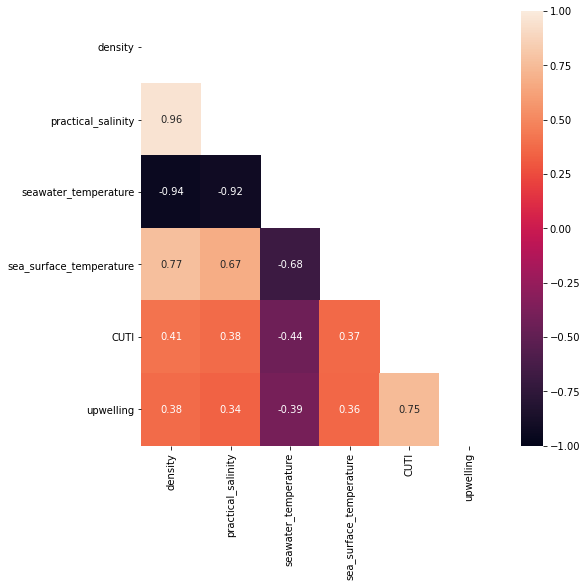

In [71]:
plt.figure(figsize=(8,8))

corr = df_resampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(df_resampled.corr(), annot=True, vmin=-1, vmax=1, mask=mask)

Yup, looks like our features are correlated with each other. I'll build a logistic regression model without addressing the multicollinearity first, and then attempt to correct for it using PolynomialFeatures and ridge and lasso penalties. 

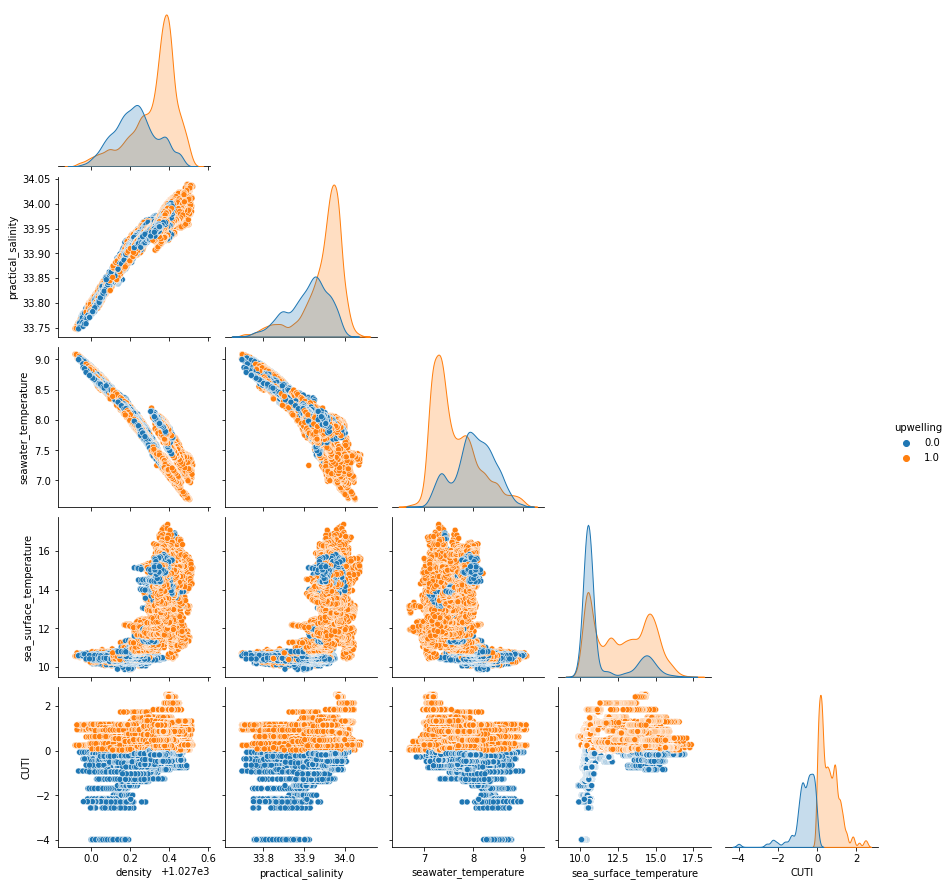

In [104]:
sns.pairplot(df_resampled, corner=True, hue='upwelling');

---
### Train test split

In [7]:
X = df_resampled.drop(columns=['time', 'CUTI', 'upwelling'])
y = df_resampled['upwelling']

In [68]:
y.value_counts(normalize=True)

1.0    0.61951
0.0    0.38049
Name: upwelling, dtype: float64

If we created a null model that labeled all predictions as the majority class, we'd be correct about 61.96% of the time! This is the accuracy I'm hoping to beat with logistic regression or decision tree models.

In [8]:
X

,density,practical_salinity,seawater_temperature,sea_surface_temperature
0,1027.258926,33.917802,7.768099,11.27030
1,1027.273454,33.923736,7.695256,11.26795
2,1027.274977,33.925383,7.688413,11.26675
3,1027.273794,33.926747,7.698557,11.26465
4,1027.255639,33.916462,7.764130,11.26475
...,...,...,...,...
17709,1027.335307,33.948736,8.005974,15.24465
17710,1027.329899,33.946218,8.028650,15.25365
17711,1027.347918,33.953680,7.949766,15.22895
17712,1027.323936,33.942572,8.052701,15.17020


In [9]:
y

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
17709    0.0
17710    0.0
17711    0.0
17712    0.0
17713    0.0
Name: upwelling, Length: 17714, dtype: float64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

---
### Scale the data


In [11]:
# Instantiate scaler:
sc = StandardScaler()

In [12]:
# Scale the data
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

---
### Building a baseline model

It's always best to start with a simple model so that you have something to compare the rest of your models to. 

In [13]:
# Instantiate model
logreg = LogisticRegression()

In [14]:
# Fit the model
logreg.fit(X_train_sc, y_train)

LogisticRegression()

In [15]:
print(f'LogReg Intercept: {logreg.intercept_}')
print(f'LogReg Coef: {logreg.coef_}')

LogReg Intercept: [0.60851976]
LogReg Coef: [[ 0.17084918 -0.60407464 -0.99386531  0.46001757]]


In [16]:
# Step 4: Evaluate model.
print(f'Train accuracy: {logreg.score(X_train_sc, y_train)}')
print(f'Test accuracy: {logreg.score(X_test_sc, y_test)}')

Train accuracy: 0.7261573202860369
Test accuracy: 0.7277037706028449


We got an initial accuracy of ~72% on the train and test data with 17714 observations, which is about 10% greater than our null model. However, this model isn't a good one because we didn't address the multicollinearity in the data. Let's add some basic interaction feature engineering and regularization to reduce the impact of this multicollinearity.

---
### GridSearch and Regularization

An easy way to get a variety of feature interactions is using sklearn's PolynomialFeatures function. There are four features in this model, so I'll set the degree to 4 so that there will be an engineered feature that includes all 4 of the original features. 

In [39]:
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)

In [40]:
X_poly = poly.fit_transform(X)
poly.get_feature_names(X.columns)

['density',
 'practical_salinity',
 'seawater_temperature',
 'sea_surface_temperature',
 'density^2',
 'density practical_salinity',
 'density seawater_temperature',
 'density sea_surface_temperature',
 'practical_salinity^2',
 'practical_salinity seawater_temperature',
 'practical_salinity sea_surface_temperature',
 'seawater_temperature^2',
 'seawater_temperature sea_surface_temperature',
 'sea_surface_temperature^2',
 'density^3',
 'density^2 practical_salinity',
 'density^2 seawater_temperature',
 'density^2 sea_surface_temperature',
 'density practical_salinity^2',
 'density practical_salinity seawater_temperature',
 'density practical_salinity sea_surface_temperature',
 'density seawater_temperature^2',
 'density seawater_temperature sea_surface_temperature',
 'density sea_surface_temperature^2',
 'practical_salinity^3',
 'practical_salinity^2 seawater_temperature',
 'practical_salinity^2 sea_surface_temperature',
 'practical_salinity seawater_temperature^2',
 'practical_salinity

Question to self: do the coefficients need to be exponentiated to get their actual values, since the logistic regression model uses the logit function to transform the data?

In [41]:
X_poly.shape

(17714, 69)

Scale the data again!

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, stratify=y, random_state=42)

In [43]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [56]:
logreg = LogisticRegression(solver='liblinear')

In [57]:
logreg_params = {
    'penalty':['l1', 'l2'],
    'C': np.linspace(0.001, 1, 10)
}

In [58]:
gs = GridSearchCV(logreg, logreg_params, cv=5, verbose=2)

In [59]:
gs.fit(X_train_sc, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.112, penalty=l1; total time=   0.7s
[CV] END ................................C=0.11

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'penalty': ['l1', 'l2']},
             verbose=2)

In [76]:
print(f'Best parameters: {gs.best_params_}')
print(f'Best score: {gs.best_score_}')

Best parameters: {'C': 0.334, 'penalty': 'l2'}
Best score: 0.7443733534060971


Now that we have the best parameters, we can create a logistic regression model with these parameters and see what the coefficients are for our poly features.

In [78]:
logreg3 = LogisticRegression(C=.334, solver='liblinear', penalty='l2')

In [79]:
logreg3.fit(X_train_sc, y_train)

LogisticRegression(C=0.334, solver='liblinear')

In [82]:
print(f'LogReg Intercept: {logreg3.intercept_}')
print(f'LogReg Coef: {logreg3.coef_}')

LogReg Intercept: [0.64179638]
LogReg Coef: [[ 0.05463415 -0.062148   -0.70540433  0.10580061  0.05672328 -0.04736196
  -0.70958883  0.1074085  -0.0055321  -0.80222133  0.1486707   0.08738078
  -0.00591653 -0.47797744  0.05881218 -0.03418924 -0.7137793   0.10901718
   0.00351988 -0.80649152  0.15030562  0.08429796 -0.00487551 -0.47610615
   0.05110224 -0.90056968  0.19196895  0.00815977  0.01591296 -0.43464806
   0.95606905  0.44133429 -0.49074913 -0.21949425  0.06090085 -0.02234978
  -0.71797579  0.11062663  0.01209778 -0.81076804  0.15194125  0.08121444
  -0.00383153 -0.47423477  0.05815368 -0.90493032  0.19362989  0.00506458
   0.01702491 -0.43276673  0.95324626  0.44089685 -0.48898002 -0.21757748
   0.10775485 -1.00051128  0.23568006 -0.0714316   0.03888975 -0.3911471
   0.88194348  0.42405695 -0.45506879 -0.17849178  1.90021848  1.34530575
  -0.3265769  -0.16207072  0.95937312]]


In [86]:
X

,density,practical_salinity,seawater_temperature,sea_surface_temperature
0,1027.258926,33.917802,7.768099,11.27030
1,1027.273454,33.923736,7.695256,11.26795
2,1027.274977,33.925383,7.688413,11.26675
3,1027.273794,33.926747,7.698557,11.26465
4,1027.255639,33.916462,7.764130,11.26475
...,...,...,...,...
17709,1027.335307,33.948736,8.005974,15.24465
17710,1027.329899,33.946218,8.028650,15.25365
17711,1027.347918,33.953680,7.949766,15.22895
17712,1027.323936,33.942572,8.052701,15.17020


['density',
 'practical_salinity',
 'seawater_temperature',
 'sea_surface_temperature',
 'density^2',
 'density practical_salinity',
 'density seawater_temperature',
 'density sea_surface_temperature',
 'practical_salinity^2',
 'practical_salinity seawater_temperature',
 'practical_salinity sea_surface_temperature',
 'seawater_temperature^2',
 'seawater_temperature sea_surface_temperature',
 'sea_surface_temperature^2',
 'density^3',
 'density^2 practical_salinity',
 'density^2 seawater_temperature',
 'density^2 sea_surface_temperature',
 'density practical_salinity^2',
 'density practical_salinity seawater_temperature',
 'density practical_salinity sea_surface_temperature',
 'density seawater_temperature^2',
 'density seawater_temperature sea_surface_temperature',
 'density sea_surface_temperature^2',
 'practical_salinity^3',
 'practical_salinity^2 seawater_temperature',
 'practical_salinity^2 sea_surface_temperature',
 'practical_salinity seawater_temperature^2',
 'practical_salinity

In [92]:
logreg3.coef_[0]

array([ 0.05463415, -0.062148  , -0.70540433,  0.10580061,  0.05672328,
       -0.04736196, -0.70958883,  0.1074085 , -0.0055321 , -0.80222133,
        0.1486707 ,  0.08738078, -0.00591653, -0.47797744,  0.05881218,
       -0.03418924, -0.7137793 ,  0.10901718,  0.00351988, -0.80649152,
        0.15030562,  0.08429796, -0.00487551, -0.47610615,  0.05110224,
       -0.90056968,  0.19196895,  0.00815977,  0.01591296, -0.43464806,
        0.95606905,  0.44133429, -0.49074913, -0.21949425,  0.06090085,
       -0.02234978, -0.71797579,  0.11062663,  0.01209778, -0.81076804,
        0.15194125,  0.08121444, -0.00383153, -0.47423477,  0.05815368,
       -0.90493032,  0.19362989,  0.00506458,  0.01702491, -0.43276673,
        0.95324626,  0.44089685, -0.48898002, -0.21757748,  0.10775485,
       -1.00051128,  0.23568006, -0.0714316 ,  0.03888975, -0.3911471 ,
        0.88194348,  0.42405695, -0.45506879, -0.17849178,  1.90021848,
        1.34530575, -0.3265769 , -0.16207072,  0.95937312])

In [96]:
list(zip(poly.get_feature_names(X.columns), logreg3.coef_[0])).sort()

None


In [98]:
sorted(list(zip(poly.get_feature_names(X.columns), logreg3.coef_[0])), key=lambda x: x[1])

[('practical_salinity^3 seawater_temperature', -1.0005112761681618),
 ('density practical_salinity^2 seawater_temperature', -0.9049303177305303),
 ('practical_salinity^2 seawater_temperature', -0.9005696810455995),
 ('density^2 practical_salinity seawater_temperature', -0.810768036913024),
 ('density practical_salinity seawater_temperature', -0.8064915229612897),
 ('practical_salinity seawater_temperature', -0.8022213319904652),
 ('density^3 seawater_temperature', -0.7179757943571895),
 ('density^2 seawater_temperature', -0.713779304463597),
 ('density seawater_temperature', -0.7095888250197461),
 ('seawater_temperature', -0.7054043300216676),
 ('seawater_temperature sea_surface_temperature^2', -0.49074912685339855),
 ('density seawater_temperature sea_surface_temperature^2',
  -0.4889800234120767),
 ('sea_surface_temperature^2', -0.4779774448436744),
 ('density sea_surface_temperature^2', -0.47610615046809357),
 ('density^2 sea_surface_temperature^2', -0.47423477131507613),
 ('practic

In [99]:
print(f'Train accuracy: {logreg3.score(X_train_sc, y_train)}')
print(f'Test accuracy: {logreg3.score(X_test_sc, y_test)}')

Train accuracy: 0.744824990590892
Test accuracy: 0.7520885075637842


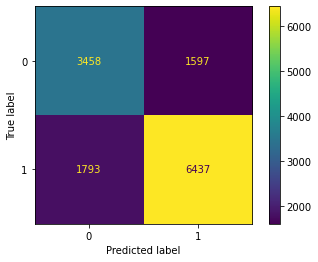

In [106]:
predictions = gs.predict(X_train_sc)

cm = confusion_matrix(y_train, predictions)
ConfusionMatrixDisplay(cm).plot();

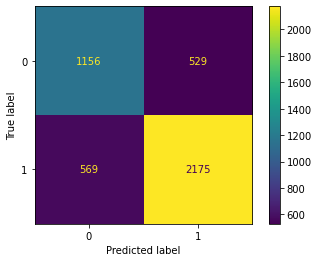

In [105]:
predictions = gs.predict(X_test_sc)

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot();

Looks like our false negatives outnumber our false positive

Need to add recall and precision classification report! 

# TODO:

Next will be trying to build a decision tree classifier as an alternative classification model that comes with interpretability. I'll also need to come back and reconsider everything I did above, there might be changes to make.